## Customer Segmentation with PCA and Clustering

Let's work end-to-end through customer segmentation using Principal Component Analysis (PCA) and clustering on a **large, built-in dataset**: the Ames Housing dataset from Scikit-Learn. This dataset contains both numerical and categorical features, making it realistic for customer analysis scenarios.

We'll:
- Load and preprocess the dataset
- Drop unnecessary columns and transform non-numeric values
- Apply PCA to find key components that explain most variance
- Identify which features are most influential for segmentation
- Use k-means (with elbow method) to find optimal number of clusters
- Plot and review the results

#### Step 1: Load and Preview the Dataset

In [127]:
from sklearn.datasets import fetch_openml
import pandas as pd

X, y = fetch_openml(data_id=42165, as_frame=True, return_X_y=True)
print(X.shape)  # lots of rows and columns
print(X.head()) # see a sample

(1460, 80)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub  ...           0        0    NaN   NaN         NaN   
1         Lvl    AllPub  ...           0        0    NaN   NaN         NaN   
2         Lvl    AllPub  ...           0        0    NaN   NaN         NaN   
3         Lvl    AllPub  ...           0        0    NaN   NaN         NaN   
4         Lvl    AllPub  ...           0        0    NaN   NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      2    200

#### Step 2: Select and Prepare Features
Let's drop columns that aren't relevant for clustering (like IDs, text comments, etc.). We'll choose ~20 key features (10 categorical, 10 numerical) for clarity:

In [128]:
categorical_columns = ["BldgType", "GarageFinish", "LotConfig", "Functional", 
                      "MasVnrType", "HouseStyle", "FireplaceQu", "ExterCond", 
                      "ExterQual", "PoolQC"]
numerical_columns = ["3SsnPorch", "Fireplaces", "BsmtHalfBath", "HalfBath", 
                    "GarageCars", "TotRmsAbvGrd", "BsmtFinSF1", "BsmtFinSF2", 
                    "GrLivArea", "ScreenPorch"]
features = categorical_columns + numerical_columns
X = X[features]

#### Step 3: Encode Categorical Features

Since clustering and PCA need numeric values, we convert categorical columns using Label Encoding (assign each category a number).

This step transforms text-based categories (like "HouseStyle") into integers for analysis.

In [129]:
from sklearn.preprocessing import LabelEncoder
for col in categorical_columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

#### Step 4: Standardize for PCA

Scaling ensures equal importance for each feature (crucial for PCA):

In [130]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Step 5: Perform Principal Component Analysis (PCA)

First, let's see how much variance each component explains, and how many are needed for >80% total variance:

- pca.explained_variance_ratio_: This is an array showing the fraction of the total variance explained by each principal component.​
    - Example: [0.38, 0.24, 0.18,...] means the first component captures 38% of the variance, the second another 24%, etc.

- np.cumsum(...): Computes a running total—so you see how much cumulative variance the first n components explain.
    - For example, the sum of the first two components might be 62%, and the sum of the first eight might reach 80%.

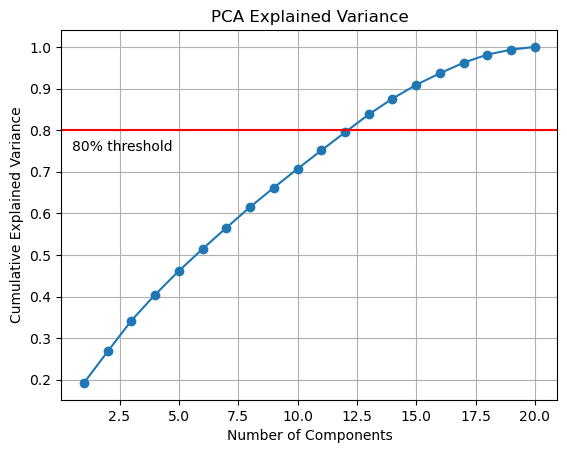

In [131]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Creates a PCA object with default settings—a tool to learn how your features vary together.
pca = PCA()

# Analyzes the scaled data to calculate the principal components (directions capturing most 
# variance), and computes statistics like how much each component contributes.
# PCA finds combinations of your input features (the principal components) that explain as 
# much variability in your data as possible.
pca.fit(X_scaled)

# Compute Cumulative Explained Variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
# marker='o': Shows each data point as a dot, making the curve clearer.

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

plt.axhline(y=0.80, color='r', linestyle='-')
plt.text(0.5, 0.75, '80% threshold')

plt.grid(True)
plt.title('PCA Explained Variance')
plt.show()

The plot rises quickly and then levels off. This is called the “elbow.” You look for the number of components where the curve approaches or passes 80%—that’s your target for dimensionality reduction.

The minimum number of components to reach ≥80% variance is 11 from the plot.

In [132]:
# Creates a PCA object with default settings—a tool to learn how your features vary together.
pca = PCA(n_components=11)

# Analyzes the scaled data to calculate the principal components (directions capturing most 
# variance), and computes statistics like how much each component contributes.
X_pca = pca.fit_transform(X_scaled)

- PCA(n_components=11): Now, set up PCA to only keep those top 11 components—compressing your dataset down to the essential directions found previously.

- pca.fit_transform(X_scaled): Both fits the PCA to your data and transforms it—outputting a new array (X_pca) where each sample is represented as 11 numbers, each corresponding to a principal component.

    - This gives you the data in a lower-dimensional space, capturing most of the meaningful variation, and is ready for clustering or other analysis.

#### Step 6: Understanding PCA Features

Which original features drive the main PCA components?

This helps answer which features (income, house type, etc.) are most influential in customer differentiation for the first few principal components.

In [133]:
loading = pca.components_  # shape: (n_components, n_features)
columns = X.columns
for i in range(11):
    # Show top contributing features to each component
    top_indices = np.argsort(np.abs(loading[i]))[::-1][:3]
    print(f'PC{i+1} is most affected by:', columns[top_indices].tolist())

PC1 is most affected by: ['GrLivArea', 'GarageCars', 'TotRmsAbvGrd']
PC2 is most affected by: ['HouseStyle', 'Fireplaces', 'FireplaceQu']
PC3 is most affected by: ['TotRmsAbvGrd', 'HalfBath', 'BldgType']
PC4 is most affected by: ['MasVnrType', 'BsmtHalfBath', 'TotRmsAbvGrd']
PC5 is most affected by: ['LotConfig', 'Functional', '3SsnPorch']
PC6 is most affected by: ['PoolQC', 'BsmtFinSF1', 'FireplaceQu']
PC7 is most affected by: ['3SsnPorch', 'Functional', 'BsmtHalfBath']
PC8 is most affected by: ['LotConfig', 'BsmtFinSF2', 'ExterCond']
PC9 is most affected by: ['3SsnPorch', 'PoolQC', 'ExterCond']
PC10 is most affected by: ['ExterCond', 'ScreenPorch', 'ExterQual']
PC11 is most affected by: ['BldgType', 'LotConfig', 'FireplaceQu']


- `loading = pca.components_`: This extracts the “coefficients” (weights) that define each principal component in terms of the original features. Shape: rows = principal components, columns = original features.
- `columns = X.columns`: Grabs the names of all features, so you can report which variables contribute most.
- `for i in range(8):`: For each of the first 8 principal components (as previously chosen for 80%+ variance).
- `np.argsort(np.abs(loading[i]))[::-1][:3]`: 
   - Sorts feature importances **by absolute value** for each component, so both positive and negative contributions count.
   - `[::-1]` reverses to descending order (largest first).
   - `[:3]` picks the top three features that contribute most.
- `columns[top_indices].tolist()`: Lists the feature names (like income, house type, pool quality, etc.) that most strongly shape the current component.
- `print(...)`: For each component, prints the top features—making it clear which characteristics differentiate segments most strongly for PCA.

**Purpose:** Let’s you answer: “What actually drives differences in this data?

#### Step 7: Clustering - Identifying Optimal Number of Clusters (k)

We'll use k-means and the elbow method to pick k.

Look for the "elbow" in the chart: that's where adding more clusters stops providing big improvements. 

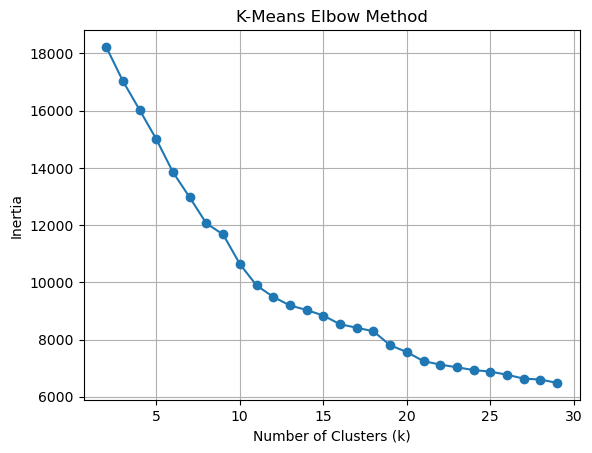

In [134]:
from sklearn.cluster import KMeans

inertias = []
k_range = range(2, 30)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_pca)
    inertias.append(km.inertia_)

plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('K-Means Elbow Method')
plt.grid(True)
plt.show()


- `KMeans`: Loads the k-means clustering tool from Scikit-Learn.
- `inertias = []`: Empty list to hold how “tight” the clustering is (lower = tighter clusters) for each value of k.
- `k_range = range(2, 11)`: Tests cluster counts from 2 to 10.
- `for k in k_range`: Loops through each candidate number of clusters.
  - `km = KMeans(n_clusters=k, random_state=42)`: Creates a k-means object with k clusters. `random_state=42` ensures reproducible results.
  - `km.fit(X_pca)`: Fits clusters to the PCA data (each sample now 8 dimensions).
  - `inertias.append(km.inertia_)`: Stashes the within-cluster sum of squares (inertia) for each value of k.
- `plt.plot(...)`: Visualizes inertia drop as clusters increase, “elbow” point shows diminishing returns on adding clusters (where improved fit starts to flatten).

**Interpretation:** Where inertia flattens, that's your candidate for “best” number of clusters (k).

##### Percent Differential for Elbow

If needed, apply the percent differential for inertias to identify an appropriate number of clusters.

- Computes the **percentage improvement** in inertia each time k increases.
- Plots this percent change vs k; you want the point where gains drop off (flattens out).
- Like with variance for PCA, a “sharp elbow” marks diminishing returns for more clusters, backing up your visual judgment.

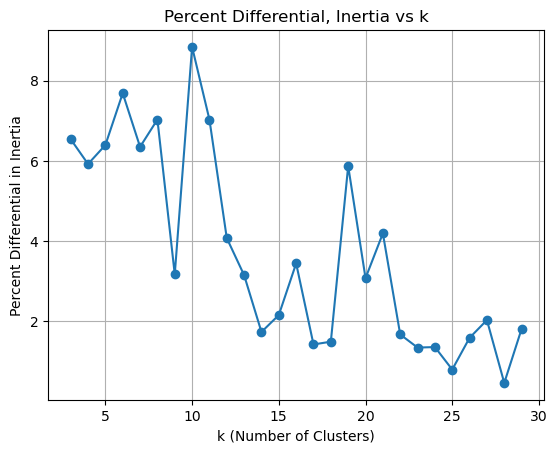

In [135]:
percent_diff = [100*(inertias[i-1] - inertias[i])/inertias[i-1] for i in range(1,len(inertias))]
plt.plot(k_range[1:], percent_diff, marker='o')
plt.xlabel('k (Number of Clusters)')
plt.ylabel('Percent Differential in Inertia')
plt.title('Percent Differential, Inertia vs k')
plt.grid(True)
plt.show()

Pick k where percent differential flattens sharply (just like the PCA variance cutoff).

#### Step 8: Fit K-Means and Plot Clusters
Let’s suppose elbow analysis points to 4 clusters.

This plot shows groupings in PCA-reduced customer space—each color is a segment.

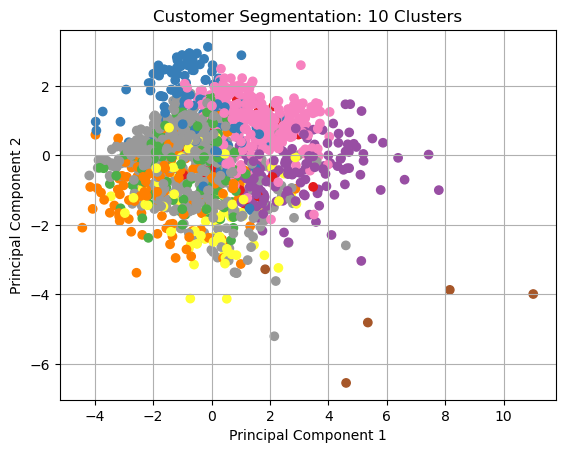

In [136]:
best_k = 10
km = KMeans(n_clusters=best_k, random_state=42)
clusters = km.fit_predict(X_pca)

plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='Set1')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'Customer Segmentation: {best_k} Clusters')
plt.grid(True)
plt.show()

- `best_k = 4`: Sets the chosen number of clusters (based on elbow).
- `km = KMeans(n_clusters=best_k, ...)` and `km.fit_predict(X_pca)`: Finds clusters and assigns each sample its group ID.
- `plt.scatter(...)`: Plots cluster assignments in PCA-reduced space (with two axes for visual clarity).
  - Colors separate different clusters, so you can immediately see how groups are divided after dimensionality reduction.

**Interpretation:** If colored blobs are distinct, clustering worked. If not, you may revisit PCA or try alternate methods.

#### Step 9: Reviewing Cluster Groups
You can now analyze the clusters: summarize key statistics for each segment.

Review which clusters have high values in particular features, or match customer archetypes for targeted marketing.

In [137]:

X_segmented = pd.DataFrame(X)
X_segmented['Cluster'] = clusters
print(X_segmented.groupby('Cluster').mean())  # mean attribute values per segment

         BldgType  GarageFinish  LotConfig  Functional  MasVnrType  \
Cluster                                                              
0        0.363636      1.045455   2.727273    5.863636    1.545455   
1        3.664384      1.095890   3.616438    5.945205    1.671233   
2        0.118750      1.650000   0.337500    5.918750    1.856250   
3        0.069444      0.305556   2.944444    5.944444    2.166667   
4        0.135338      1.872180   3.007519    5.661654    1.819549   
5        0.350000      1.500000   3.337500    2.837500    1.912500   
6        0.000000      0.800000   1.600000    6.000000    1.800000   
7        0.099668      0.847176   2.890365    5.990033    1.564784   
8        0.138539      1.690176   3.977330    5.939547    1.806045   
9        0.236111      1.180556   3.027778    5.875000    1.527778   

         HouseStyle  FireplaceQu  ExterCond  ExterQual    PoolQC   3SsnPorch  \
Cluster                                                                        

- `X_segmented = pd.DataFrame(X)`: Converts your feature data back to a DataFrame for summary.
- `X_segmented['Cluster'] = clusters`: Adds cluster memberships.
- `X_segmented.groupby('Cluster').mean()`: Groups data by each cluster and calculates the mean for all features within each group.
  - Tells you the “typical” attribute profile of each segment.
- **Interpretation:** Examine which clusters have highest values for income, certain house styles, pool quality, etc. This helps characterize and target each customer segment for business actions (e.g., marketing).

#### Summary:

- We used a realistic, mixed-feature dataset and dropped irrelevant columns.
- Categorical data was encoded for analysis.
- PCA found main segments and revealed top features driving differentiation.
- Elbow/plotted inertias chose optimal clusters.
- K-means produced segments, visualized in PCA space.

##### Sources:

[1](https://hex.tech/templates/data-clustering/customer-segmentation/)
[2](https://www.geeksforgeeks.org/machine-learning/encoding-categorical-data-in-sklearn/)
[3](https://scikit-learn.org/stable/modules/clustering.html)
[4](https://stackoverflow.com/questions/40795141/pca-for-categorical-features)
[5](https://www.kaggle.com/code/fhabibimoghaddam/customer-segmentation-k-means-clustering-pca)
[6](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_categorical.html)
[7](https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html)
[8](https://www.kaggle.com/code/ponybiam/feature-engineering-2-clustering-pca)
[9](https://www.datacamp.com/tutorial/principal-component-analysis-in-python)
[10](https://towardsdatascience.com/famd-how-to-generalize-pca-to-categorical-and-numerical-data-2ddbeb2b9210/)